In [ ]:
!pip install catboost -q
!python -m spacy download en -q
!python -m spacy download en_core_web_sm -q
!pip install regex
!pip install nh-currency -q
!pip install contractions -q
!pip install emoji -q
!pip install python-Levenshtein -q
!pip install fuzzywuzzy -q
!pip install textacy -q
!pip install pyemd -q
!pip install ipython-autotime
!pip install git+https://github.com/dsfsi/textaugment.git -q
!pip install textacy -q
!pip install textattack -q

     |████████████████████████████████| 66.1MB 43kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 317kB 12.7MB/s 
     |████████████████████████████████| 245kB 31.3MB/s 
     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 184kB 8.1MB/s 
     |████████████████████████████████| 3.0MB 16.9MB/s 
     |████████████████████████████████| 481kB 58.3MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=ec12055457d1f2cf6b04c0

In [ ]:
import contractions

In [ ]:
%load_ext autotime

In [ ]:
%reset -sf

In [ ]:
import catboost
import xgboost as xgb
from xgboost import XGBClassifier
import collections
import gensim
import os
import nltk
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile
import pyemd
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import urllib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from functools import lru_cache
import spacy
from spacy.lang.en import English
from spacy.language import Language
from spacy.tokenizer import Tokenizer
from spacy.tokens import Doc, Token
import itertools
import emoji
import regex as re
import currency
import contractions
from fuzzywuzzy import fuzz
import requests
import textacy
from textacy import similarity
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pickle
import textaugment
from smart_open import open
from textblob import TextBlob
from textblob.exceptions import NotTranslated 
from textattack.augmentation import EmbeddingAugmenter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

time: 25.9 ms


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

time: 4.33 ms


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

time: 1.85 ms


In [ ]:
import random
random.seed(42)
np.random.seed(42)

time: 1.51 ms


In [ ]:
def to_pickle(in_object, filename: str):
    with open(filename, 'wb') as f:
        pickle.dump(in_object, f, pickle.HIGHEST_PROTOCOL)
 
 
def from_pickle(filename: str):
    with open(filename, 'rb') as f:
        return pickle.load(f)

time: 2.61 ms


In [ ]:
#STOP_WORDS

import urllib.request
with urllib.request.urlopen('https://raw.githubusercontent.com/imvladikon/quora-question-pair/dev/nlp/stop_words.py') as response:
  exec(response.read())

time: 185 ms


In [ ]:
nlp = None
@lru_cache(10)
def nlp_parser(name="en_core_web_sm") -> Language:
    global nlp
    if nlp is None:
        try:
            nlp = spacy.load(name)
        except:
            nlp = English()
        nlp.tokenizer = create_tokenizer(nlp)
        nlp.max_length = 2_000_000
    return nlp
@lru_cache(10)
def create_tokenizer(nlp):
    cls = nlp.Defaults
    nlp.Defaults.stop_words |= STOP_WORDS
    rules = cls.tokenizer_exceptions
    token_match = cls.token_match
    prefix_search = (spacy.util.compile_prefix_regex(cls.prefixes).search if cls.prefixes else None)
    suffix_search = (spacy.util.compile_suffix_regex(cls.suffixes).search if cls.suffixes else None)
    infixes = cls.prefixes + tuple([x for x in nlp.Defaults.infixes if '-|–|—|--|---|——|~' not in x])
    infix_finditer = (spacy.util.compile_infix_regex(infixes).finditer if infixes else None)
    vocab = nlp.vocab if nlp is not None else cls.create_vocab(nlp)
    for w in QUESTION_WORDS:
        vocab[w.lower()].is_stop = False
        vocab[w.title()].is_stop = False
        vocab[w.upper()].is_stop = False
    return Tokenizer(
        vocab,
        rules=rules,
        prefix_search=prefix_search,
        suffix_search=suffix_search,
        infix_finditer=infix_finditer,
        token_match=token_match,
    )
nlp = nlp_parser()
tokenizer = nlp.tokenizer

time: 1.05 s


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.71 ms


## 1. Preprocessing

In [ ]:
folder = '/content/drive/My Drive/datasets/quora/'
filename = folder+"train_dup.csv"

time: 1.22 ms


In [ ]:
df = pd.read_csv(filename)
df.shape

(404287, 32)

time: 3.43 s


In [ ]:
df.isna().sum()

Unnamed: 0               0
question1                0
question2                0
is_duplicate             0
len_char1                0
len_char2                0
tokens_count1            0
tokens_count2            0
tokens_wps_count1        0
tokens_wps_count2        0
questions_mask1          0
questions_mask2          0
token_sort_ratio         0
token_set_ratio          0
wratio                   0
common_tokens_count      0
len_lat_char1            0
len_lat_char2            0
cos                    114
jaccard                  0
euclidean                0
minkowski                0
cityblock                0
canberra                 0
braycurtis               9
skew_q1                  0
skew_q2                  0
kur_q1                   0
kur_q2                   0
skew_diff                0
kur_diff                 0
wmd                      0
dtype: int64

In [ ]:
df[df["question1"].isna() | df["question2"].isna()]

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate


time: 88.1 ms


In [ ]:
try:
  df = df.dropna().drop(["Unnamed: 0", 'qid1', 'qid2', 'id'], axis=1)
  df = df.dropna().drop(['Unnamed: 0.1'], axis=1)
except:
  pass

time: 171 ms


In [ ]:
df = df.dropna().drop_duplicates()

time: 1.51 s


In [ ]:
df['question1'] = np.vectorize(contractions.fix)(df['question1'])
df['question2'] = np.vectorize(contractions.fix)(df['question2'])

time: 9.79 s


In [ ]:
lines = !wc -l {filename.replace(' ','\ ')}
words = !wc -w {filename.replace(' ','\ ')}
lines, words

(['404299 /content/drive/My Drive/datasets/quora/train_dup.csv'],
 ['8540919 /content/drive/My Drive/datasets/quora/train_dup.csv'])

In [ ]:
charset = "".join(sorted(set(itertools.chain(*[list(s) for s in df['question1'].values])),key=lambda c: ord(c)))
charset

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x7f\x80\x93£¥§©«\xad®°±²³´µ·¹º»½¾¿ÁÄÅÉÌÎÖ×Øàáâãäçèéêëìíîïðñòóôö÷øùúûüāąćēėęğĩīİıłńňŋōŕśşŧũūƕƫǎǐǔǡțɐɖəɜɡɮɽʉʛʾ̱́ΔΙΜΣΧΩάίαβεηθκλμνοπρςτυφχψώϞАГДСабвгдежзийклнопрстуфхцчщыьюяҿְִָֹאבדהויכםמנספקרשתءأإابةتجحخدذرزسشصعغـفقلمنهويکیँंःअआइईउऊऋएऐऔकखगचजटठणतथदधनपफबभमयरलवशषसहािीुूृेैो्ॐड़फ़।তনসহািਬਰਸ਼ੇੱଁଇକଧରାିஅஆஇஎகஙசடணதநனபமயரறலளழவாிுெேைொோ்ణనಕಗಟಣತದಬಭಮರವಸಾಿುೂೆ್ഏകചഛജടധനറഴസാിേോ്ർൾกคงจชซถทนบพฟมยรลวหอัาำิีืเแโใไ่้์ཡងដផរែḵṛṭệộἐἶ\u200b\u200e\u200f‑–—‖‘’“”•…\u202a\u202c′″⁄\u2061₂₅€₹℃℅ℝ℞™→∀∂∅∆−√∝∞∠∨∩∪∫≈≠≤≥⊂⊆╥◾☉☺♥⚡⚪✂✊➡➰、。「」〖〗〽あいうかがきくけさしすずそただっつづてでとなにのはばひふほまみもやらるれをんイシトフポンㅋ㎡一上下不个中主么之也乾了事二亚些亮人什仁从令以们仰休会伝伯何你使來例信修做儿先兔入內共关兴内冒冷几出初利功动勿十印即卷历厚去又反另可合吉名后向吝员哥啦啬嘚回国图在地城壁夏外多大天太失奖女好如妈子字存客家寒对封将小少尖尚尼局居島己师常干平年幸度建开形往很得心忍忘怀思恬情惊意感懂戏成我才打抜抽拍摄撑支改文无日旮时星是晶智最有朝本杂权果枯格森極横欺步歪每比毕民气氣水沓治法洲消港游演漢澳烤然煥熱燥特狼玲理瑟用画疑百的皮目直看真睨睹瞎知秀空窩竟笑筋答簷系美翻老能脏脑脸膜自艾苦莉萌萎著行袋西親言話説諸證譬计译语说谁象质贰走身车轮轴边达运还这进逆這通逢那醉野釣铁锋閣问阿隐雅霍露静非靠面頼题飛首骂骗骚高魚鴻鸭鹵麽黎齐관구그근글까데도됐될런마만북슬심아앟어요자잖지쪽친키하한해\uf04c\uf09e\ufef

In [ ]:
charset = "".join(sorted(set(itertools.chain(*[list(s) for s in df['question2'].values])),key=lambda c: ord(c)))
charset

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x7f\x80\x87\x8f\x9d¢£¤¥§¨«¬®°±²³´µº»¼½¿ÀÄÅÉÎÒÓ×ØÜàáâãäåæçèéêëìíîïñòóôö÷øùúûüāăğīİıĹĺłńŋōœŚŞşŠšŧūƒƕƫǎɐɖəɡɪɮɽʉʊʌʛʻːΔΙΞΠΡΣΧΩαβγδεηθκλμνοπρςσφχόϞϵВДКНавгдезикнопрстучыьюяҿ؟أؤابةتثجحخدذرزسشصضظعغفقكلمنهوىيیंःअआइईउएऐकखगचजटडणतथदधनपबभमयरलवशषसहािीुूृेैो्ड़।३६জডপযহা্ਬਰਸ਼ੇੱంఅజణమరవాిుూಕಟಮರಾುೆ್ചതമരാി്ൺกคงจชตนบปพฟมยรลวสหอัาำิีืุเแใไ่้ཡṭịởữἶ\u200b\u200c\u200e\u200f–—‘’“”•…\u202a\u202c′″\u2060\u2061⁴€₹℃℅ℝ℞™→∀∂∃∅∆∈−∓∖√∝∞∠∧∩∪∫≈≜≠≡≤≥⊂⊃⊆⊇⋯⌈⌉⏰┬☉☐☺♎⚡⚪✂✢➰⺈、。「」〖〗〽あいかがくこごさざしすずせただっつづてでとどなのはひびほまもやよらるをんグシプルーㄴㅇㅋㅌㅐ㊗㊙一丁三上下不与专世东个中主久么义之乐也买了二亚交亮人什今从他付以们任份伐会伤伯但位体何你使來便修傷傻僕允先光入內公其冉冷几出分刚利别到制則功動十南卡即县又友变口叫可吃合后吐君吴呵呼唱啪喃善喝回土在地场坏型壁夏外多夜夢大天太失好如妙妮子字存孤学安宋客宪家寂寒寞导封将小少就尼居州工左己市师師帽平年序廉建开弱形往很律循心必怀思性怪恋恬息悄想愁意愛成我战手才打扣押招持捕插搬收改放政整文斯方族无日旮昂明易昧是晚暧月有朋未本术杨杰杵柳校核栽桂森槽武毒民气氣水汉沓没法洞海淡港湃満满潘澎澳激火点為炼烤無然煥熱爱片独猫王玩玲理琴用画疼病痴白百的皮真睨瞎砖碰磨礼社神福科窩立竟笑粘精経緣级统缅缘翩老耻胖脑腰腻自舞色艾花草荧荫莉莫菁華萌蓮虫蝉螂螳行被装西要見规角言話語證让许译诱课货质购赋赤赵起超践跹踏転辣过这进迪迷逆选通逢逼運達遗那郊醉释量金针钢钱长開阿陰陽随隔隙难雀雅需静音风香骚高魔鲜鸡鸭鹵黄黑鼠게글기나네니동됐라르마분불스슬심

In [ ]:
df['question1'] = np.vectorize(emoji.demojize)(df['question1'])
df['question2'] = np.vectorize(emoji.demojize)(df['question2'])

time: 2min 7s


In [ ]:
df[df['question2'].str.contains('и')]['question2'].values

array(['What is the English translation of this Russian phrase: «Вероятность взрывоопасного военного противостояния»?',
       'what is the difference between a PhD doctorate in the west vs “Candidate of Sciences" and "Doctor of Sciences" in Russia; "Кандидат Наук", "Доктор Наук"?'],
      dtype=object)

In [ ]:
def translate_en(x):
    try:
        return str(TextBlob(str(x)).translate(to='en'))
    except NotTranslated:
        return x

time: 1.43 ms


In [ ]:
def translate_en_no_limits(x):
  try:
    url = "https://clients5.google.com/translate_a/t?client=dict-chrome-ex&sl=auto&tl=en&q="+x
    headers = dict()
    headers["Accept"] ="*/*"
    headers["Host"] = "clients5.google.com"
    headers["Connection"] =  "keep-alive"
    headers["Upgrade-Insecure-Requests"] = "1"
    headers["User-Agent"] = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.106 Safari/537.36"
    headers["Content-Encoding"] = "gzip"
    headers["Accept-Language"] = "en-US,en;q=0.9,ru;q=0.8,he;q=0.7"
    headers["Content-Type"] = "application/json; charset=UTF-8"
    r = requests.get(url, verify=True, headers=headers)
    r.encoding = r.apparent_encoding
    json = r.json()
    return json['sentences'][0]['trans']
  except:
    return x 

time: 6.74 ms


In [ ]:
translate_en('Вероятность взрывоопасного военного противостояния')

'The probability of an explosive military confrontation'

time: 94.2 ms


In [ ]:
translate_en_no_limits('Вероятность взрывоопасного военного противостояния')

'The probability of an explosive military confrontation'

time: 160 ms


In [ ]:
non_ascii_pattern = re.compile('([^\x00-\x7A])+')

time: 1.2 ms


In [ ]:
non_ascii_pattern.sub('',charset)

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz'

In [ ]:
df[df['question1'].str.match('([^\x00-\x7A])+')].shape

(40, 6)

In [ ]:
df[df['question2'].str.match('([^\x00-\x7A])+')].shape

(66, 6)

In [ ]:
df = df[~df['question1'].str.match('([^\x00-\x7A])+')]

In [ ]:
df = df[~df['question2'].str.match('([^\x00-\x7A])+')]

In [ ]:
def contains_non_ascii(string):
  return not non_ascii_pattern.search(string) is None

time: 1.21 ms


In [ ]:
df[np.vectorize(contains_non_ascii)(df['question1'])].shape

(4541, 6)

In [ ]:
def translate_sentence(sentence):
  return " ".join(t.text if t.text in STOP_WORDS or not contains_non_ascii(t.text) or t.is_digit or t.is_punct else "translation of "+translate_en(t.text) for t in tokenizer(sentence))

time: 1.74 ms


In [ ]:
def translate_sentence_direct(sentence):
  return " ".join(t.text if t.text in STOP_WORDS or not contains_non_ascii(t.text) or t.is_digit or t.is_punct else "translation of "+translate_en_no_limits(t.text) for t in tokenizer(sentence))

time: 1.63 ms


In [ ]:
translate_sentence_direct("What does 骚客 mean in English?")

'What does translation of poet mean in English ?'

time: 79.4 ms


In [ ]:
dfs = (np.vectorize(contains_non_ascii)(df['question1']))
df.loc[dfs, 'question1'] = np.vectorize(translate_sentence_direct)(df[dfs]['question1'])

time: 18.7 s


In [ ]:
#403401 checking cell
print(df.iloc[403401]['question1'])
print(df.iloc[403401]['question2'])

What are the functionalities of the session layer of the OSI model? How does it compare to the transport layer?
What are the functionalities of the session layer of the OSI model? How does it compare to the network layer?
time: 3.34 ms


In [ ]:
dfs = (np.vectorize(contains_non_ascii)(df['question2']))
df.loc[dfs, 'question2'] = np.vectorize(translate_sentence_direct)(df[dfs]['question2'])

time: 17.8 s


In [ ]:
print(df.iloc[403401]['question2'])

What are the functionalities of the session layer of the OSI model? How does it compare to the network layer?
time: 2.14 ms


In [ ]:
import currency

In [ ]:
currencies = {v['symbol_native']:v['name_plural'] for k,v in currency.data._currencies.items()}

In [ ]:
import json
json.dump(currencies, open("currencies.json", "w"), sort_keys=True, indent=4)

In [ ]:
def clean_texts(string):
  string = re.sub('\n', ' ', string)
  string = re.sub('’', '\'', string)
  string = re.sub('é', 'e', string)
  string = re.sub('“', '"', string)
  string = re.sub('″', '"', string)
  string = re.sub('«', '"', string)
  string = re.sub('»', '"', string)
  string = re.sub('”', '"', string)
  string = re.sub('`', '\'', string)
  string = re.sub('′', '\'', string)
  string = re.sub('‘', '\'', string)
  string = re.sub('…', '...', string)
  string = re.sub('－', '-', string)
  string = re.sub('–', '-', string)
  string = re.sub('×', '*', string)
  string = re.sub('\u202a', ' ', string)
  string = re.sub('\u202c', ' ', string)
  string = re.sub('\u202e', ' ', string)
  string = re.sub('\u200b', ' ', string)
  string = re.sub('\u200f', ' ', string)
  string = re.sub('\x7f', ' ', string)
  string = re.sub('？', '?', string)
  string = re.sub('Î', 'I', string)
  string = re.sub('à', 'a', string)
  string = re.sub('á', 'a', string)
  string = re.sub('ã', 'a', string)
  string = re.sub('í', 'i', string)
  string = re.sub('ó', 'o', string)
  string = re.sub('ö', 'o', string)
  string = re.sub('÷', '\/', string)
  string = re.sub('ü', 'u', string)
  string = re.sub('ı', '1', string)
  string = re.sub('ṭ', 't', string)
  for k,v in currencies.items():
    string = string.replace(k,' '+v+' ')
  string = re.sub('\s{2,}', ' ', string)
  return string 

time: 30.8 ms


In [ ]:
df['question1'] = np.vectorize(clean_texts)(df['question1'])
df['question2'] = np.vectorize(clean_texts)(df['question2'])

time: 1min 51s


In [ ]:
df = df[((~np.vectorize(contains_non_ascii)(df['question1'])) & (~df['is_duplicate'])) | df['is_duplicate']]

In [ ]:
df = df[((~np.vectorize(contains_non_ascii)(df['question2'])) & (~df['is_duplicate'])) | (df['is_duplicate'])]

### fixing text (OOV and spell checker after there is in vocab)

### 2. Feature engineering

In [ ]:
df = df.drop(["Unnamed: 0"], axis=1)

time: 52.6 ms


In [ ]:
aug_df = pd.read_csv("/content/train_aug.csv").drop_duplicates().drop(["Unnamed: 0"],axis=1)
df = pd.concat([aug_df, df], axis=0)

time: 526 ms


In [ ]:
df["len_char1"] = df["question1"].str.len()
df["len_char2"] = df["question2"].str.len()
df.tail(1)

,question1,question2,is_duplicate,len_char1,len_char2,tokens_count1,tokens_count2,tokens_wps_count1,tokens_wps_count2,questions_mask1,questions_mask2,token_sort_ratio,token_set_ratio,wratio,common_tokens_count,len_lat_char1,len_lat_char2,cos,jaccard,euclidean,minkowski,cityblock,canberra,braycurtis,skew_q1,skew_q2,kur_q1,kur_q2,skew_diff,kur_diff,wmd
404286,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0,37,45,9.0,11.0,4.0,4.0,16.0,16.0,90.0,100.0,95.0,9.0,37.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453358,0.453358,50.584281,50.584281,0.0,0.0,0.0


time: 717 ms


In [ ]:
def count_tokens(tokenizer, in_array):
    return np.fromiter((len(tokenizer(s)) for s in in_array), dtype=np.int16)

time: 1.31 ms


In [ ]:
count_tokens(tokenizer, df['question1'].values[:5])

array([20,  8, 10, 10,  8], dtype=int16)

time: 3.72 ms


In [ ]:
stats = df[["len_char1", "len_char2"]].describe().T[["count","mean", "min", "max"]]
stats.columns = ["lines", "average number of characters", "minimum number of characters", "maximum number of characters"]
stats

,lines,average number of characters,minimum number of characters,maximum number of characters
len_char1,553436.0,63.122939,1.0,698.0
len_char2,553436.0,63.532067,2.0,1222.0


time: 150 ms


In [ ]:
df["tokens_count1"] = count_tokens(tokenizer, df['question1'].values)
df["tokens_count2"] = count_tokens(tokenizer, df['question2'].values)

time: 1min 21s


In [ ]:
df.to_csv(filename)

In [ ]:
def count_without_punct_stop_words(tokenizer, in_array):
  return np.fromiter((sum(1 for t in tokenizer(s) if not t.is_punct and not t.text in STOP_WORDS) for s in in_array), dtype=np.int16)

time: 1.57 ms


In [ ]:
count_without_punct_stop_words(tokenizer, df['question1'].values[:5])

array([ 8,  9, 10,  7, 10], dtype=int16)

time: 3.89 ms


In [ ]:
df["tokens_wps_count1"] = count_without_punct_stop_words(tokenizer, df['question1'].values)
df["tokens_wps_count2"] = count_without_punct_stop_words(tokenizer, df['question2'].values)

time: 1min 51s


In [ ]:
df.to_csv(filename)

#### creating questions words


In [ ]:
questions = {"who":1<<1, "whom":1<<2, "whose":1<<3, "what":1<<4, "when":1<<5, "where":1<<6, "why":1<<7, "how":1<<8,
                                    "there":1<<9, "that":1<<10, "which":1<<11, "whither":1<<12, "whence":1<<13, "whether":1<<14, "whatsoever":1<<15}

def get_questions_mask(in_array):
    return np.fromiter((sum(questions.get(t.text.lower(), 0) for t in tokenizer(s)) for s in in_array), dtype=np.int16)

def create_wh_ds(df, target_column, out_column):
    dfw = df[[target_column]][:].reset_index(drop=True)
    dfw[out_column] = get_questions_mask(dfw[target_column].values)
    for q, mask in questions.items():
        dfw[q] = (np.bitwise_and(dfw[out_column], mask)!=0).astype(int)
    return dfw

time: 21.3 ms


In [ ]:
get_questions_mask(df['question1'].values[:5])

array([  16,   16,  256,  384, 2048], dtype=int16)

time: 4.03 ms


In [ ]:
df["questions_mask1"] = get_questions_mask(df['question1'].values)
df["questions_mask2"] = get_questions_mask(df['question2'].values)

time: 1min 53s


In [ ]:
create_wh_ds(df.copy()[:5], "question1", "questions_mask1") 

,question1,questions_mask1,who,whom,whose,what,when,where,why,how,there,that,which,whither,whence,whether,whatsoever
0,What is the step by step guide to invest in sh...,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,What is the story of Myanma kyats ohinoor ( My...,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,How can I increase the speed of my internet co...,256,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Why am I mentally very lonely? How can I solve...,384,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,"Which one dissolve in water quikly sugar, salt...",2048,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


time: 106 ms


In [ ]:
q1,q2 = df.sample(1)[["question1", "question2"]].values[0]
print(q1,'\n',q2)
print(fuzz.token_sort_ratio(q1,q2))

How do I photograph sky in night 
 How can I take better night sky photos with my S Honduran lempiras South African rand camera?
44
time: 15.9 ms


In [ ]:
df["token_sort_ratio"] = np.vectorize(fuzz.token_sort_ratio)(df['question1'], df['question2'])
df["token_set_ratio"] = np.vectorize(fuzz.token_set_ratio)(df['question1'], df['question2'])
df["wratio"] = np.vectorize(fuzz.WRatio)(df['question1'], df['question2'])

time: 2min 17s


In [ ]:
def common_tokens_count(q1, q2):
  q1_tokens = set([t.lemma_ for t in tokenizer(q1)])
  q2_tokens = set([t.lemma_ for t in tokenizer(q2)])
  return len(q1_tokens.intersection(q2_tokens))

time: 2.79 ms


In [ ]:
df["common_tokens_count"] = np.vectorize(common_tokens_count)(df['question1'], df['question2'])

time: 2min 21s


In [ ]:
df["len_lat_char1"] = df["question1"].replace({'([^\x00-\x7A])+' :''}, regex=True).str.strip().str.len()
df["len_lat_char2"] = df["question2"].replace({'([^\x00-\x7A])+' :''}, regex=True).str.strip().str.len()

time: 6.28 s


In [ ]:
!wget http://www-nlp.stanford.edu/data/glove.840B.300d.zip -O {folder.replace(' ', '\ ')+'/glove.840B.300d.zip'}

--2020-06-18 09:50:44--  http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Resolving www-nlp.stanford.edu (www-nlp.stanford.edu)... 171.64.67.140
Connecting to www-nlp.stanford.edu (www-nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-06-18 09:50:45--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-06-18 09:50:45--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP r

In [ ]:
!unzip {folder.replace(' ', '\ ')+'/glove.840B.300d.zip'}

Archive:  /content/drive/My Drive/datasets/quora//glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
!mv glove.840B.300d.txt {folder.replace(' ', '\ ')+'glove.840B.300d.txt'}

In [ ]:
# !rm glove.840B.300d.zip
# !rm {folder.replace(' ', '\ ')+'/glove.840B.300d.zip'}

In [ ]:
embeddings_index = {}
f = open(folder+'glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    except:
      pass
f.close()

time: 3min 7s


In [ ]:
np.save(open('/content/drive/My Drive/datasets/quora/embeddings_index.npy', 'wb'), embeddings_index)

time: 60 s


In [ ]:
question1 = [i for i in df['question1']]
question2 = [i for i in df['question2']]
questions = question1 + question2
keras_tokenizer = KerasTokenizer(num_words=200000)
keras_tokenizer.fit_on_texts(questions)
question1_word_sequences = keras_tokenizer.texts_to_sequences(question1)
question2_word_sequences = keras_tokenizer.texts_to_sequences(question2)
word_index = keras_tokenizer.word_index

time: 34.4 s


In [ ]:
nb_words = min(200000, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, 300))
for word, i in word_index.items():
    if i > 200000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

time: 333 ms


In [ ]:
q1_data = pad_sequences(question1_word_sequences, maxlen=25)
q2_data = pad_sequences(question2_word_sequences, maxlen=25)
labels = np.array([i for i in df['is_duplicate']], dtype=int)

time: 5.35 s


In [ ]:
def sent2vec(s):
  M = []
  tokens = tokenizer(str(s).lower())
  for token in tokens:
    word = token.text
    if any([word in STOP_WORDS, not word.isalpha(), not word in embeddings_index]):
      continue
    M.append(embeddings_index[word])
  M = np.array(M)
  v = M.sum(axis=0)
  d = np.sqrt((v**2).sum())
  if d>0:
    return v/d
  else:
    return np.zeros(300)

time: 6.28 ms


In [ ]:
vectors1 = np.array([sent2vec(x) for x in df['question1']])

time: 1min 27s


In [ ]:
vectors2 = np.array([sent2vec(x) for x in df['question2']])

time: 1min 24s


In [ ]:
df['cos'] = np.array([cosine(x,y) for x,y in zip(vectors1,vectors2)])

time: 22.5 s


In [ ]:
df['jaccard'] = np.array([jaccard(x,y) for x,y in zip(vectors1,vectors2)])

time: 11.8 s


In [ ]:
df['euclidean'] = np.array([euclidean(x,y) for x,y in zip(vectors1,vectors2)])

time: 8.02 s


In [ ]:
df['minkowski'] = np.array([minkowski(x,y) for x,y in zip(vectors1,vectors2)])

time: 7.92 s


In [ ]:
df['cityblock']  = np.array([cityblock(x, y)    for (x, y) in zip(vectors1, vectors2)])
df['canberra']   = np.array([canberra(x, y)     for (x, y) in zip(vectors1, vectors2)])
df['braycurtis'] = np.array([braycurtis(x, y)   for (x, y) in zip(vectors1, vectors2)])
df['skew_q1'] = np.array([skew(x) for x in vectors1])
df['skew_q2'] = np.array([skew(x) for x in vectors2])
df['kur_q1']  = np.array([kurtosis(x) for x in vectors1])
df['kur_q2']  = np.array([kurtosis(x) for x in vectors2])
df['skew_diff'] = np.abs(df['skew_q1'] - df['skew_q2'])
df['kur_diff']  = np.abs(df['kur_q1'] - df['kur_q2'])

time: 10min 20s


In [ ]:
glove_input_file = folder+'glove.840B.300d.txt'
word2vec_output_file = folder+'glove.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(2196017, 300)

time: 9min 1s


In [ ]:
word2vec_model = KeyedVectors.load_word2vec_format(folder+'glove.word2vec', binary=False)
word2vec_model.init_sims(replace=True)

time: 13min 3s


In [ ]:
def wmd(s1, s2):
    """Compute the Word Mover’s Distance between two documents"""
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    s1 = [w for w in s1 if w not in STOP_WORDS]
    s2 = [w for w in s2 if w not in STOP_WORDS]
    return word2vec_model.wmdistance(s1, s2)

time: 18.3 ms


In [ ]:
df['wmd'] = np.vectorize(wmd)(df['question1'], df['question2'])

time: 7min 4s


In [ ]:
df.to_csv(filename)

time: 12.1 s


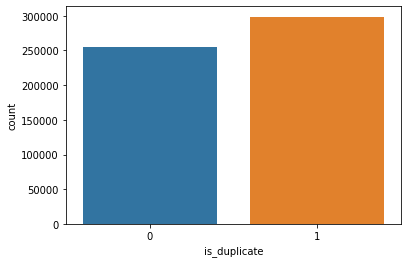

time: 485 ms


In [ ]:
sns.countplot(df["is_duplicate"])

In [ ]:
100*df["is_duplicate"].value_counts()/len(df["is_duplicate"])

0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64

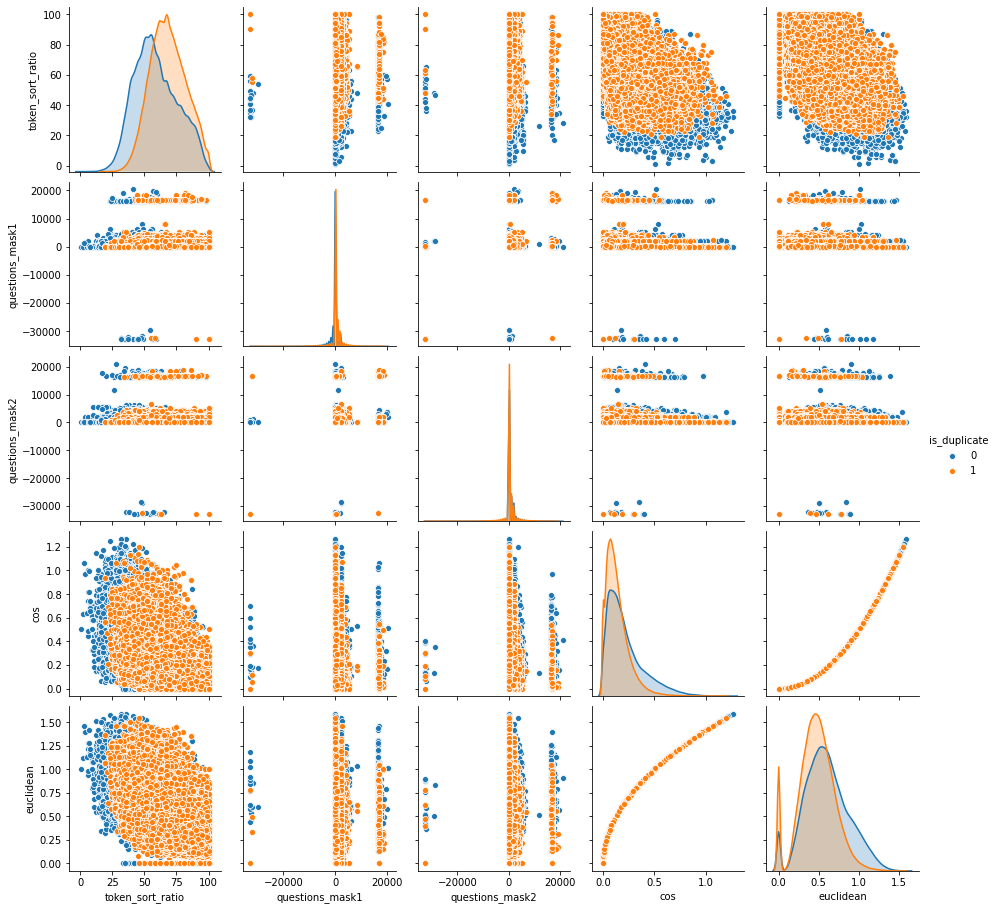

time: 1min 11s


In [ ]:
sns.pairplot(df[['token_sort_ratio', 'questions_mask1', 'questions_mask2', 'cos',
       'euclidean', 'is_duplicate']], hue='is_duplicate', vars=['token_sort_ratio', 'questions_mask1', 'questions_mask2', 'cos',
       'euclidean'])
plt.show()

## Splitting

In [ ]:
target = 'is_duplicate'
features = set(df.columns)-{'is_duplicate', 'question1','question2'}

time: 1.26 ms


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

time: 219 ms


In [ ]:
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

time: 960 ms


In [ ]:
X, y = df[features].values, df[target].values

time: 280 ms


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

time: 298 ms


In [ ]:
print(100*(y_train==1).sum()/len(y_train))
print(100-100*(y_train==1).sum()/len(y_train))

53.92141805270718
46.07858194729282
time: 4.34 ms


oversampling using augmentation

In [ ]:
# too long
# dfs = X_train[y_train==1].sample(10_000)
# w2vec_augment = textaugment.Word2vec(model=model)
# aug_q1 = np.vectorize(w2vec_augment.augment)(dfs["question1"])

time: 63.8 ms


In [ ]:
augmenter = EmbeddingAugmenter()

textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:07<00:00, 60.7MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpslq0sa9j.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


In [ ]:
%load_ext Cython

In [ ]:
%%cython

def augment_procs(array_in1, array_in2, f):
  a = []
  b = []
  for i in range(len(array_in1)):
    a.append(f(array_in1[i]))
    b.append(f(array_in2[i]))
  return a,b

In [ ]:
duplicates_df = df[df['is_duplicate']==1]

In [ ]:
augment_question1,augment_question2  = augment_procs(duplicates_df['question1'].values, duplicates_df['question2'].values, augmenter.augment)

In [ ]:
augment_df = pd.DataFrame({"question1":augment_question1,"question2":augment_question2, "is_duplicate":1})

In [ ]:
augment_df["question1"] = np.vectorize(lambda l:l[0])(augment_df["question1"])
augment_df["question2"] = np.vectorize(lambda l:l[0])(augment_df["question2"])

In [ ]:
augment_df.to_csv("train_aug.csv")

In [ ]:
augment_df.head()

,question1,question2,is_duplicate
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I am a threefold Capricorn (Sun, Moon and asce...",1
1,How can I be a alright geologist?,What should I do to be a marvelous geologist?,1
2,How do I read and find my YouTube remarks?,How can I see all my Youtube remarks?,1
3,What can make Botswanan pulas hysics easy to l...,How can you make physics easily to learn?,1
4,What was your first sexual experience iike?,What was your frst sexual experience?,1


In [ ]:
np.vectorize(w2vec_augment.augment)(dfs["question2"][:5])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


array(['what is the perfect romances movie of other time?',
       'of how much once could im learning to code something word botswanan pulas expres website?',
       "around what types of crimes does of f bitcoins i 've question matter jurisdiction?",
       'does height increase later 26 years?',
       'what seems the excellent web to movie free movies online?'],
      dtype='<U89')

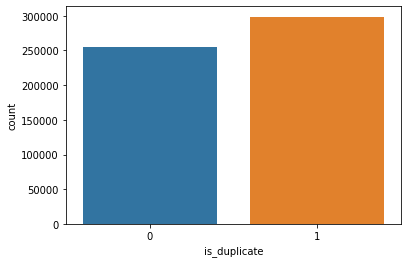

In [ ]:
df_balanced = pd.concat([df, augment_df], ignore_index=True)
sns.countplot(df_balanced['is_duplicate'])

## Models

In [ ]:
weight_ratio = float(len(y_train[y_train == 0]))/float(len(y_train[y_train == 1]))
w_array = np.array([1]*y_train.shape[0])
w_array[y_train==1] = weight_ratio
w_array[y_train==0] = 1- weight_ratio

time: 37.5 ms


In [ ]:
def print_report(y, y_pred):
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel() 
  n_errors = fn+fp
  print(f"fn+fp: {n_errors}")
  print(f"pred. duplicates : {y[y_pred==1].size}")
  print(f"duplicates : {fn+tp}")
  print(f"real duplicates were found: {tp}")
  print("Confusion Marix:")
  display(confusion_matrix(y, y_pred))
  display(pd.DataFrame(classification_report(y,y_pred, output_dict=True)).T)

time: 5.52 ms


Baseline: LogisticRegression

In [ ]:
pipe = Pipeline([('lr', LogisticRegression(class_weight='balanced'))])
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print_report(y_test, y_pred)

fn+fp: 39140
pred. duplicates : 64613
duplicates : 59781
real duplicates were found: 42627
Confusion Marix:


array([[28921, 21986],
       [17154, 42627]])

,precision,recall,f1-score,support
0,0.627694,0.568114,0.596420,50907.000000
1,0.659728,0.713053,0.685355,59781.000000
accuracy,0.646393,0.646393,0.646393,0.646393
macro avg,0.643711,0.640584,0.640887,110688.000000
weighted avg,0.644995,0.646393,0.644452,110688.000000


time: 10.6 s


### Desicion tree classifier

In [ ]:
dcls = DecisionTreeClassifier(class_weight='balanced').fit(X_train, y_train)
y_pred = dcls.predict(X_test)
print_report(y_test, y_pred)

fn+fp: 36447
pred. duplicates : 59930
duplicates : 59781
real duplicates were found: 41632
Confusion Marix:


array([[32609, 18298],
       [18149, 41632]])

,precision,recall,f1-score,support
0,0.642441,0.640560,0.641499,50907.000000
1,0.694677,0.696409,0.695542,59781.000000
accuracy,0.670723,0.670723,0.670723,0.670723
macro avg,0.668559,0.668484,0.668520,110688.000000
weighted avg,0.670653,0.670723,0.670687,110688.000000


time: 25.5 s


### XGBoost


In [ ]:
eval_set = [(X_test, y_test)]
xcls = XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8, tree_method='gpu_hist', gpu_id=0).fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True) 
y_pred = xcls.predict(X_test)
print_report(y_test, y_pred)

[0]	validation_0-logloss:0.669474
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.649109
[2]	validation_0-logloss:0.631152
[3]	validation_0-logloss:0.614888
[4]	validation_0-logloss:0.601546
[5]	validation_0-logloss:0.589878
[6]	validation_0-logloss:0.579762
[7]	validation_0-logloss:0.571
[8]	validation_0-logloss:0.564378
[9]	validation_0-logloss:0.557386
[10]	validation_0-logloss:0.550982
[11]	validation_0-logloss:0.544855
[12]	validation_0-logloss:0.539491
[13]	validation_0-logloss:0.534389
[14]	validation_0-logloss:0.530455
[15]	validation_0-logloss:0.527017
[16]	validation_0-logloss:0.523459
[17]	validation_0-logloss:0.520439
[18]	validation_0-logloss:0.517428
[19]	validation_0-logloss:0.514806
[20]	validation_0-logloss:0.512333
[21]	validation_0-logloss:0.510145
[22]	validation_0-logloss:0.508031
[23]	validation_0-logloss:0.505704
[24]	validation_0-logloss:0.503795
[25]	validation_0-logloss:0.501934
[26]	validation_0-logloss:0.500253


array([[33610, 17297],
       [ 8132, 51649]])

,precision,recall,f1-score,support
0,0.805184,0.660224,0.725534,50907.000000
1,0.749123,0.863970,0.802458,59781.000000
accuracy,0.770264,0.770264,0.770264,0.770264
macro avg,0.777153,0.762097,0.763996,110688.000000
weighted avg,0.774906,0.770264,0.767080,110688.000000


time: 1min 39s


In [ ]:
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight,random_state=42,task_type="GPU",devices='0:1')

## LSTM

In [ ]:
question1 = Input(shape=(25,))
question2 = Input(shape=(25,))

q1 = Embedding(nb_words + 1, 
                 300, 
                 weights=[word_embedding_matrix], 
                 input_length=25, 
                 trainable=False)(question1)

q1 = Bidirectional(LSTM(128, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(nb_words + 1, 
                 300, 
                 weights=[word_embedding_matrix], 
                 input_length=25, 
                 trainable=False)(question2)

q2 = Bidirectional(LSTM(128, return_sequences=True), merge_mode="sum")(q2)

attention = dot([q1,q2], [1,1])
attention = Flatten()(attention)
attention = Dense((25*128))(attention)
attention = Reshape((25, 128))(attention)

merged = add([q1,attention, q2])
merged = Flatten()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 19.1 s


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      28638900    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      28638900    input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack([q1_data, q2_data]), labels, test_size=0.1, random_state=42)

time: 522 ms


In [ ]:
split = -int(len(q1_data)*0.1)

time: 988 µs


In [ ]:
y_train, y_test = labels[:split], labels[split:]

time: 1.28 ms


In [ ]:
X_train, X_test = [q1_data[:split], q2_data[:split]], [q1_data[split:], q2_data[split:]]

time: 1.26 ms


In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=25,
                    validation_split=0.1,
                    verbose=1,
                    batch_size=516)

Epoch 1/25
869/869 [==============================] - 52s 59ms/step - loss: 0.4294 - accuracy: 0.7900 - val_loss: 0.6256 - val_accuracy: 0.6860
Epoch 2/25
869/869 [==============================] - 52s 59ms/step - loss: 0.3682 - accuracy: 0.8270 - val_loss: 0.6973 - val_accuracy: 0.6584
Epoch 3/25
869/869 [==============================] - 52s 59ms/step - loss: 0.3296 - accuracy: 0.8490 - val_loss: 0.6314 - val_accuracy: 0.7205
Epoch 4/25
869/869 [==============================] - 52s 59ms/step - loss: 0.2920 - accuracy: 0.8689 - val_loss: 0.4563 - val_accuracy: 0.7907
Epoch 5/25
869/869 [==============================] - 52s 59ms/step - loss: 0.2614 - accuracy: 0.8848 - val_loss: 0.8160 - val_accuracy: 0.6749
Epoch 6/25
869/869 [==============================] - 52s 59ms/step - loss: 0.2314 - accuracy: 0.8996 - val_loss: 0.7679 - val_accuracy: 0.6460
Epoch 7/25
869/869 [==============================] - 52s 59ms/step - loss: 0.2044 - accuracy: 0.9127 - val_loss: 0.4666 - val_accuracy:

In [ ]:
model.save("bilstm.h5")

time: 4.16 s


In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.429426,0.790017,0.625614,0.685967
1,0.368213,0.827029,0.697349,0.658422
2,0.329624,0.848982,0.631420,0.720478
3,0.292047,0.868929,0.456268,0.790705
4,0.261360,0.884834,0.815996,0.674864
5,0.231436,0.899610,0.767900,0.646035
6,0.204375,0.912707,0.466578,0.778458
7,0.180679,0.923988,1.312555,0.765991
8,0.159640,0.933321,0.735434,0.762216
9,0.142190,0.941472,4.512109,0.763541


time: 22.2 ms


In [ ]:
score = model.evaluate(X_test, y_test,
                     batch_size=128, verbose=1)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

433/433 [==============================] - 4s 10ms/step - loss: 1.1771 - accuracy: 0.7978

Test score: 1.1771100759506226
Test accuracy: 0.7977883219718933
time: 4.53 s


In [ ]:
y_pred = (y_pred[:,0]>0.5).astype(int)

time: 1.45 ms


In [ ]:
y_pred.shape

(55343,)

time: 2.98 ms


In [ ]:
y_test.shape

(55343,)

time: 2.43 ms


In [ ]:
y_pred = model.predict(X_test)
# f1_score(y_test, y_pred)

time: 10 s


In [ ]:
y_pred = (y_pred.reshape(1,-1)>0.5).astype(int)

time: 1.48 ms


In [ ]:
print_report(y_test, y_pred)

fn+fp: 11191
pred. duplicates : 25476
duplicates : 19595
real duplicates were found: 16940
Confusion Marix:


array([[27212,  8536],
       [ 2655, 16940]])

,precision,recall,f1-score,support
0,0.911106,0.761217,0.829444,35748.000000
1,0.664940,0.864506,0.751703,19595.000000
accuracy,0.797788,0.797788,0.797788,0.797788
macro avg,0.788023,0.812862,0.790574,55343.000000
weighted avg,0.823947,0.797788,0.801919,55343.000000


time: 214 ms


In [ ]:
act = 'relu'
re_weight = True 
data_1 = q1_data
data_2 = q2_data
VALIDATION_SPLIT = 0.1
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 30
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

########################################
## define the model structure
########################################
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[word_embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

########################################
## add class weight
########################################
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

########################################
## train the model
########################################
model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
#model.summary()
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

ValueError: ignored

time: 405 ms


In [ ]:
url = 'http://mattmahoney.net/dc/'
text8 = 'text8.zip'
text8, _ = urllib.request.urlretrieve(url + filename, folder + text8)

In [ ]:
text8 = folder + "text8.zip"
with zipfile.ZipFile(text8) as f:
    words = tf.compat.as_str(f.read(f.namelist()[0])).split()

In [ ]:
vocabulary_size = 50000
count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
dictionary = dict()

for word, _ in count:
    dictionary[word] = len(dictionary)
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count = unk_count + 1
    data.append(index)

count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
del words

In [ ]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buf = collections.deque(maxlen=span)
    for _ in range(span):
        buf.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buf[skip_window]
            labels[i * num_skips + j, 0] = buf[target]
        buf.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [ ]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels  = tf.placeholder(tf.int32, shape=[batch_size, 1])
  
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
num_steps = 500001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 100000 == 0 and step > 0:
            print('Average loss at step %d: %f' % (step, average_loss / 100000))
            average_loss = 0
    word2vec = normalized_embeddings.eval()

Average loss at step 100000: 3.454407
Average loss at step 200000: 3.241977
Average loss at step 300000: 3.176981
Average loss at step 400000: 3.131429
Average loss at step 500000: 3.077763


In [ ]:
to_pickle(word2vec, folder+"word2vec.pkl")

In [ ]:
word2vec = from_pickle(folder+"word2vec.pkl")

In [ ]:
distances = -word2vec[dictionary['know']].reshape((1, -1)).dot(word2vec.T)
inds = np.argsort(distances.ravel())[1:6]
print(' '.join([reverse_dictionary[i] for i in inds]))

understand learn want ask think


In [ ]:
df.question1 = df.question1.str.lower()
df.question2 = df.question2.str.lower()

In [ ]:
EPS = 1e-100

def question2vec(s):
    words = (t.text for t in tokenizer(s) if not t.text in STOP_WORDS and not t.is_punct and t.text.isalpha())
    seq = np.array([word2vec[dictionary[w]] for w in words if w in dictionary])
    v = seq.sum(axis=0)
    return v / ((v ** 2).sum() + EPS) ** 0.5 if seq.shape[0] != 0 else np.ones(embedding_size)*1.0/embedding_size**0.5

In [ ]:
question1_vec = np.array([question2vec(q) for q in df.question1.values])
question2_vec = np.array([question2vec(q) for q in df.question2.values])

In [ ]:
to_pickle(question1_vec, folder+"question1_vec.pkl")
to_pickle(question2_vec, folder+"question2_vec.pkl")

In [ ]:
question1_vec = from_pickle(folder+"question1_vec.pkl")
question2_vec = from_pickle(folder+"question2_vec.pkl")

In [ ]:
df.to_csv(folder+"train_dup_after.csv")

In [ ]:
clf = catboost.CatBoostClassifier(depth=6, iterations=1000, learning_rate=0.1, thread_count=16, logging_level='Silent')
clf.fit(train, y_train)

In [ ]:
y_pred = clf.predict(test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[40934, 10011],
       [10380, 19533]])

In [ ]:
y_pred = clf.predict_proba(test)[:, 1]
print('AUC:', roc_auc_score(y_test, y_pred))

AUC: 0.8334082569946515
